# Deep Learning Models

In [16]:
import pandas as pd
import numpy as np

def load_tweets(path):
    with open(path, "rb") as f:
        import pickle
        e_tweets = pickle.load(f)
    return e_tweets

In [4]:
tweets = load_tweets(path = "data/clean_text.pkl")
labels = load_tweets(path = "data/Sentiment_Labels.pkl")

In [7]:
tweets_df = pd.DataFrame(data={'tweets': tweets, 'label': labels})
tweet, label = tweets_df.loc[tweets_df.label != 0, :].tweets, tweets_df.loc[tweets_df.label != 0, :].label

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
   tweet, label, train_size=0.8, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(27993,) (6999,)


In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

max_len = 140
embedding_dim = 32

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
x_train = tokenizer.texts_to_sequences(X_train)
x_test = tokenizer.texts_to_sequences(X_test)

train = sequence.pad_sequences(x_train, maxlen = max_len)
test = sequence.pad_sequences(x_test, maxlen = max_len)

vocab_size = len(tokenizer.word_index) + 1
print(f'Vocab Size: {vocab_size}')


/srv/conda/envs/data100/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/srv/conda/envs/data100/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/srv/conda/envs/data100/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/srv/conda/envs/data100/lib/python3.6/site-packages/tensorflow/python/framework

Vocab Size: 17508


# Baseline Model

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Activation

base_model = Sequential()
base_model.add(Embedding(vocab_size, embedding_dim, input_length = max_len))
base_model.add(Flatten())
base_model.add(Dense(1, activation='sigmoid'))
base_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 140, 32)           560256    
_________________________________________________________________
flatten_4 (Flatten)          (None, 4480)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 4481      
Total params: 564,737
Trainable params: 564,737
Non-trainable params: 0
_________________________________________________________________


In [59]:
base_model.fit(train, y_train, epochs = 10, batch_size = 30, verbose=1)

Epoch 1/10
27993/27993 [==============================] - 5s 173us/step - loss: -4.4323 - acc: 0.6675
Epoch 2/10
27993/27993 [==============================] - 5s 163us/step - loss: -4.4876 - acc: 0.6718
Epoch 3/10
27993/27993 [==============================] - 5s 192us/step - loss: -4.5304 - acc: 0.6763
Epoch 4/10
27993/27993 [==============================] - 5s 165us/step - loss: -4.5622 - acc: 0.6797
Epoch 5/10
27993/27993 [==============================] - 5s 169us/step - loss: -4.5853 - acc: 0.6822
Epoch 6/10
27993/27993 [==============================] - 5s 164us/step - loss: -4.6053 - acc: 0.6832
Epoch 7/10
27993/27993 [==============================] - 4s 160us/step - loss: -4.6187 - acc: 0.6853
Epoch 8/10
27993/27993 [==============================] - 5s 167us/step - loss: -4.6302 - acc: 0.6860
Epoch 9/10
27993/27993 [==============================] - 5s 167us/step - loss: -4.6428 - acc: 0.6878
Epoch 10/10
27993/27993 [==============================] - 5s 163us/step - loss: -

In [60]:
loss, accuracy = base_model.evaluate(test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.5835


# Word2Vec

In [12]:
import gensim
from gensim.models import word2vec, KeyedVectors, Word2Vec

In [68]:
tokens = X_train.apply(lambda x: x.split())

num_features = 300          
min_word_count = 10                      
num_workers = 8
window = 10 
w2v_epochs = 32

w2v_model = word2vec.Word2Vec(size = num_features, window = window, min_count = min_word_count, 
                              workers = num_workers)

w2v_model.build_vocab(tokens)

In [70]:
w2v_model.train(tokens, total_examples = len(tokens), epochs = w2v_epochs)

(6437016, 8061120)

In [77]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

word_vectors = w2v_model.wv
vocab_tmp = list(word_vectors.vocab)

X = w2v_model[vocab_tmp]
pca = PCA(n_components = 2).fit_transform(X)

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


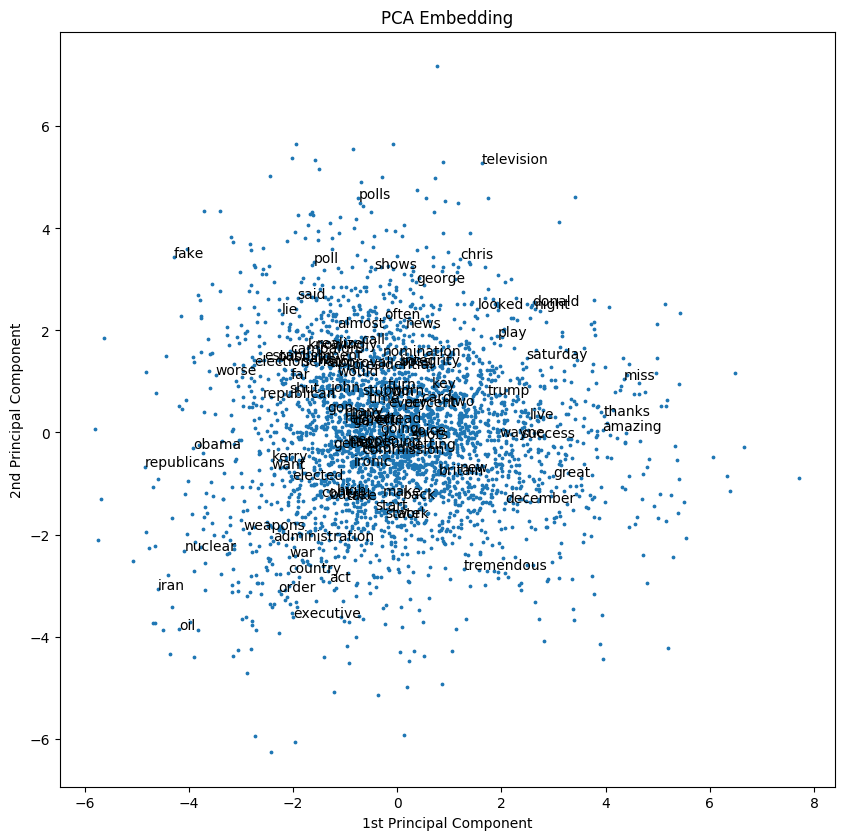

In [78]:
plt.figure(figsize=(10,10),dpi=100)

df = pd.concat([pd.DataFrame(pca), pd.Series(vocab_tmp)], axis=1)
df.columns = ['x', 'y', 'word']

plt.xlabel("1st Principal Component")
plt.ylabel('2nd Principal Component')


plt.scatter(x = pca[:, 0], y = pca[:, 1], s = 3)
for i, word in enumerate(df['word'][0:100]):
    plt.annotate(word, (df['x'].iloc[i], df['y'].iloc[i]))
plt.title("PCA Embedding")
plt.show()

In [79]:
w2v_model.most_similar('trump')

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('trumpforpresident', 0.3393762707710266),
 ('stuff', 0.3390505015850067),
 ('ya', 0.3334254324436188),
 ('definitely', 0.31823068857192993),
 ('landmark', 0.317394495010376),
 ('elect', 0.3146878778934479),
 ('thx', 0.3114921450614929),
 ('tcot', 0.30869537591934204),
 ('exclusive', 0.30713075399398804),
 ('hey', 0.30370545387268066)]

In [80]:
w2v_model.most_similar('fox')

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('greta', 0.5857903361320496),
 ('wallace', 0.5679925680160522),
 ('chris', 0.540320634841919),
 ('listening', 0.505423903465271),
 ('cable', 0.4957653880119324),
 ('minutes', 0.4908280670642853),
 ('abc', 0.4859207272529602),
 ('radio', 0.4807280898094177),
 ('msnbc', 0.46167320013046265),
 ('cbs', 0.4565206468105316)]

In [81]:
w2v_model.most_similar('china')

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('chinese', 0.6078228950500488),
 ('manipulation', 0.6015561819076538),
 ('currency', 0.5803742408752441),
 ('opec', 0.5763264894485474),
 ('treasury', 0.5530341863632202),
 ('oil', 0.5066781640052795),
 ('laugh', 0.4987688660621643),
 ('tariffs', 0.4961910843849182),
 ('japan', 0.4948878884315491),
 ('countries', 0.49311399459838867)]

In [82]:
w2v_model.most_similar('mexico')

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('tariffs', 0.5797913074493408),
 ('plant', 0.5588988661766052),
 ('cars', 0.5526720285415649),
 ('mexican', 0.5481626391410828),
 ('trade', 0.5334032773971558),
 ('southern', 0.5267270803451538),
 ('produce', 0.52374267578125),
 ('canada', 0.5041123628616333),
 ('cancel', 0.48837822675704956),
 ('wall', 0.4818826913833618)]

In [83]:
w2v_model.most_similar('trade')

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('deals', 0.6277050971984863),
 ('tariffs', 0.5723737478256226),
 ('farmers', 0.5713272094726562),
 ('mexico', 0.5334032773971558),
 ('japan', 0.5296262502670288),
 ('cars', 0.5096592307090759),
 ('negotiators', 0.502869725227356),
 ('negotiated', 0.5025371313095093),
 ('nafta', 0.5009671449661255),
 ('companies', 0.4810084104537964)]

In [84]:
w2v_model.most_similar('maga')

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('trumppence', 0.6963237524032593),
 ('imwithyou', 0.6472546458244324),
 ('americafirst', 0.6254812479019165),
 ('kag', 0.6230806112289429),
 ('colorado', 0.6071087121963501),
 ('votetrump', 0.60384601354599),
 ('maine', 0.6011710166931152),
 ('arizona', 0.5910359025001526),
 ('wisconsin', 0.5880006551742554),
 ('departing', 0.5627131462097168)]

In [85]:
w2v_model.most_similar('dems')

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('democrats', 0.653983473777771),
 ('dem', 0.6102787256240845),
 ('votes', 0.5736371278762817),
 ('democrat', 0.5647380948066711),
 ('republicans', 0.5242307186126709),
 ('increases', 0.5036899447441101),
 ('partisan', 0.49507319927215576),
 ('wi', 0.4926573932170868),
 ('opponents', 0.486750066280365),
 ('sham', 0.4863821268081665)]

In [87]:
w2v_model.most_similar('clinton')

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('crooked', 0.6903309226036072),
 ('emails', 0.6059390306472778),
 ('mail', 0.5785791873931885),
 ('podesta', 0.5587329864501953),
 ('rigged', 0.5498247742652893),
 ('e', 0.5432493686676025),
 ('beating', 0.5315985679626465),
 ('server', 0.5086430907249451),
 ('mails', 0.4981616139411926),
 ('beat', 0.49414142966270447)]

In [88]:
w2v_model.most_similar('korea')

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('korean', 0.7730749845504761),
 ('jong', 0.6356285214424133),
 ('north', 0.6241601705551147),
 ('kim', 0.6197041273117065),
 ('un', 0.6101192235946655),
 ('carolina', 0.5827369689941406),
 ('amounts', 0.5566794276237488),
 ('japan', 0.5226253271102905),
 ('missile', 0.5146039724349976),
 ('nuclear', 0.5083788633346558)]

In [90]:
w2v_model.most_similar('liberals')

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('exactly', 0.5328895449638367),
 ('knowing', 0.5211573839187622),
 ('lack', 0.5004627704620361),
 ('churchill', 0.4978232979774475),
 ('obviously', 0.49534350633621216),
 ('admit', 0.4884564280509949),
 ('winston', 0.48785626888275146),
 ('trust', 0.4874556064605713),
 ('ppl', 0.482769250869751),
 ('scared', 0.48018234968185425)]

In [91]:
w2v_model.most_similar('help')

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('desperately', 0.46111151576042175),
 ('quick', 0.44178780913352966),
 ('marine', 0.43704527616500854),
 ('resources', 0.4101315140724182),
 ('stopped', 0.39458924531936646),
 ('alaska', 0.38697749376296997),
 ('donate', 0.369131863117218),
 ('protection', 0.36878839135169983),
 ('send', 0.3656095266342163),
 ('trail', 0.36003053188323975)]

In [92]:
w2v_model.most_similar('love')

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('admire', 0.4990633726119995),
 ('inspiration', 0.4461749792098999),
 ('awesome', 0.4284957945346832),
 ('ur', 0.40285906195640564),
 ('hate', 0.400732159614563),
 ('loving', 0.374795526266098),
 ('passion', 0.37445923686027527),
 ('shit', 0.3701680302619934),
 ('joan', 0.3686226010322571),
 ('buffalo', 0.3675856590270996)]

In [93]:
w2v_model.most_similar('great')

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('fantastic', 0.6701199412345886),
 ('incredible', 0.5351399183273315),
 ('amazing', 0.47923868894577026),
 ('tremendous', 0.47887539863586426),
 ('wonderful', 0.47007840871810913),
 ('exciting', 0.4168210029602051),
 ('proud', 0.4167030453681946),
 ('arrived', 0.4153571128845215),
 ('awesome', 0.4118695557117462),
 ('excellent', 0.40317589044570923)]

# CNN with Trained Embeddings

In [37]:
embedding_matrix = np.zeros((vocab_size, num_features))
for word, i in tokenizer.word_index.items():
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]
print(embedding_matrix.shape)

(17508, 300)


In [132]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D

cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size, num_features, weights = [embedding_matrix], input_length = max_len))
cnn_model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(250, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(cnn_model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 140, 300)          5252400   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 140, 32)           28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 70, 32)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2240)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 250)               560250    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 251       
Total params: 5,841,733
Trainable params: 5,841,733
Non-trainable params: 0
_________________________________________________________________


In [133]:
cnn_model.fit(train, y_train, epochs = 10, batch_size = 30, verbose=1)

/srv/conda/envs/data100/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
27993/27993 [==============================] - 53s 2ms/step - loss: -1.8802 - acc: 0.5270
Epoch 2/10
27993/27993 [==============================] - 48s 2ms/step - loss: -3.0004 - acc: 0.6056
Epoch 3/10
27993/27993 [==============================] - 40s 1ms/step - loss: -3.4632 - acc: 0.6318
Epoch 4/10
27993/27993 [==============================] - 41s 1ms/step - loss: -3.7222 - acc: 0.6447
Epoch 5/10
27993/27993 [==============================] - 42s 1ms/step - loss: -3.9355 - acc: 0.6552
Epoch 6/10
27993/27993 [==============================] - 48s 2ms/step - loss: -4.0496 - acc: 0.6595
Epoch 7/10
27993/27993 [==============================] - 43s 2ms/step - loss: -4.1354 - acc: 0.6635
Epoch 8/10
27993/27993 [==============================] - 46s 2ms/step - loss: -4.2231 - acc: 0.6653
Epoch 9/10
27993/27993 [==============================] - 45s 2ms/step - loss: -4.2832 - acc: 0.6675
Epoch 10/10
27993/27993 [==============================] - 40s 1ms/step - loss: -4.2827 - a

In [134]:
loss, accuracy = cnn_model.evaluate(test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.6054


# LSTM with pre-trained GloVe Embeddings

In [38]:
path = "/home/jovyan/Trump_Twitter_Sentiment_Analysis/data/glove.6B.100d.txt"

def create_embedding_matrix(filepath, num_features):
    embedding_matrix = np.zeros((vocab_size, num_features))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_vectors:
                embedding_matrix[i] = word_vectors[word]
    return embedding_matrix

In [39]:
glove_embedding_matrix = create_embedding_matrix(path, num_features)

In [41]:
from tensorflow.keras.layers import LSTM, Dropout
rnn_model = Sequential()
rnn_model.add(Embedding(vocab_size, num_features, weights = [glove_embedding_matrix], input_length = max_len))
rnn_model.add(Dropout(0.5))
rnn_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
rnn_model.add(Dense(1, activation='sigmoid'))
rnn_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 140, 300)          5252400   
_________________________________________________________________
dropout (Dropout)            (None, 140, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 5,412,901
Trainable params: 5,412,901
Non-trainable params: 0
_________________________________________________________________


In [43]:
rnn_model.fit(train, y_train, epochs = 10, batch_size = 128, verbose=1)

Epoch 1/10
27993/27993 [==============================] - 197s 7ms/step - loss: -2.4465 - acc: 0.5677
Epoch 2/10
27993/27993 [==============================] - 199s 7ms/step - loss: -3.2946 - acc: 0.6112
Epoch 3/10
27993/27993 [==============================] - 206s 7ms/step - loss: -3.6556 - acc: 0.6313
Epoch 4/10
27993/27993 [==============================] - 189s 7ms/step - loss: -3.8649 - acc: 0.6443
Epoch 5/10
27993/27993 [==============================] - 191s 7ms/step - loss: -3.9943 - acc: 0.6531
Epoch 6/10
27993/27993 [==============================] - 193s 7ms/step - loss: -4.0863 - acc: 0.6567
Epoch 7/10
27993/27993 [==============================] - 189s 7ms/step - loss: -4.1418 - acc: 0.6609
Epoch 8/10
27993/27993 [==============================] - 191s 7ms/step - loss: -4.1619 - acc: 0.6617
Epoch 9/10
27993/27993 [==============================] - 191s 7ms/step - loss: -4.2315 - acc: 0.6668
Epoch 10/10
27993/27993 [==============================] - 191s 7ms/step - loss: -

In [44]:
loss, accuracy = rnn_model.evaluate(test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.6169
